In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# mpl soccer imports
from mplsoccer import Pitch, VerticalPitch, Sbopen, FontManager
from mplsoccer.dimensions import center_scale_dims
from mplsoccer.utils import FontManager


import plotly.graph_objects as go
from PIL import Image
import io


import json
import streamlit as st

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import FunctionTransformer

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

import os
import sys
sys.path.append(os.path.abspath("../src"))

from preprocessing_utils import clean_categories


## Use the statsbomb api open data and combine all the EPL games in 2003-2004 and 2015-2016

In [2]:
# # Get competitions
# competitions_df = sb.competitions()
# pl_df = competitions_df[competitions_df['competition_name'] == 'Premier League']

# epl_id = pl_df['competition_id'].iloc[0]
# epl_id

# # Get season ID 
# league_id = pl_df['season_id']
# league_id


# all_leagues = []  # Initialize an empty list
# for league in league_id:
#     events_df = sb.matches(competition_id=epl_id, season_id=league)
#     all_leagues.append(events_df)  # Append each DataFrame to the list

# # Concatenate all DataFrames into one big DataFrame
# combined_leagues = pd.concat(all_leagues, ignore_index=True)
# combined_leagues

#### Filter to specific season

In [3]:
# combined_leagues_2015 = combined_leagues[combined_leagues['match_date'] > "2014-01-01"]
# combined_leagues_2015

#### Output all the events for EPL

In [4]:
# # Filter for epl_team matches

# # Get match IDs of first epl_team matches
# match_id = combined_leagues_2015['match_id']

# all_events = []  # Initialize an empty list

# for match in match_id:
#     events_df = sb.events(match_id=match)
#     all_events.append(events_df)  # Append each DataFrame to the list

# # Concatenate all DataFrames into one big DataFrame
# combined_df = pd.concat(all_events, ignore_index=True)


#### Save teams's data to a csv file in the data folder to save time on executing the code above again

In [5]:
# combined_df.to_csv("../data/epl2015_events.csv", index=False)

#### Load teams's data: Check for balance in data to avoid biases

In [6]:
team_df = pd.read_csv('../data/epl2015_events.csv')
team_df['team'].value_counts()

C:\Users\vchan\AppData\Local\Temp\ipykernel_5712\3829361932.py:1: DtypeWarning: Columns (9,11,16,17,18,19,22,27,36,44,45,51,75,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  team_df = pd.read_csv('../data/epl2015_events.csv')


team
Arsenal                 78077
Manchester City         77267
Liverpool               75525
Manchester United       75358
Chelsea                 73972
Tottenham Hotspur       72649
Swansea City            70122
Everton                 70042
AFC Bournemouth         68417
Stoke City              63894
Southampton             63649
Aston Villa             62534
Newcastle United        61920
West Ham United         60925
Norwich City            59035
Watford                 58985
Crystal Palace          58189
Leicester City          56567
Sunderland              54447
West Bromwich Albion    52209
Name: count, dtype: int64

#### Team shot attemps

In [7]:
team_df['shot_outcome'].value_counts()

shot_outcome
Off T               3197
Blocked             2880
Saved               2209
Goal                 988
Wayward              396
Post                 170
Saved Off Target      45
Saved to Post         23
Name: count, dtype: int64

#### Filter to only shot opportunities if we are looking at goals

In [8]:
team_shots = team_df[team_df['type']=='Shot'].copy()
print(team_shots.shape)
team_shots.sample(3)

(9908, 118)


,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,...,block_save_block,shot_deflected,player_off_permanent,goalkeeper_success_in_play,shot_follows_dribble,goalkeeper_lost_out,half_start_late_video_start,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post
1046528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### All values for under pressure will be True or False

In [9]:
team_shots['under_pressure'].fillna(False, inplace=True)
team_shots.sample(3)

C:\Users\vchan\AppData\Local\Temp\ipykernel_5712\2955556846.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_shots['under_pressure'].fillna(False, inplace=True)
C:\Users\vchan\AppData\Local\Temp\ipykernel_5712\2955556846.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  team_shots['under_pressure'].fi

,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,...,block_save_block,shot_deflected,player_off_permanent,goalkeeper_success_in_play,shot_follows_dribble,goalkeeper_lost_out,half_start_late_video_start,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,goalkeeper_saved_to_post
727214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
914677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Main features we might be interested in when looking at shooting

In [10]:
team_shots_shortened = team_shots[['period', 'position', 'minute', 'possession_team', 'play_pattern', 'location', 'shot_body_part', 'shot_outcome','under_pressure', 'type']].copy()
team_shots_shortened.sample(3)

,period,position,minute,possession_team,play_pattern,location,shot_body_part,shot_outcome,under_pressure,type
1001534,2,Center Attacking Midfield,93,West Bromwich Albion,Regular Play,"[112.4, 38.2]",Head,Off T,False,Shot
866296,2,Center Attacking Midfield,71,Chelsea,From Throw In,"[101.5, 49.2]",Right Foot,Blocked,False,Shot
847744,1,Center Forward,14,Watford,Regular Play,"[111.5, 54.4]",Right Foot,Blocked,False,Shot


#### Add x and y features instead of location

In [11]:
import ast

team_shots_shortened['location'] = team_shots_shortened['location'].apply(ast.literal_eval)
team_shots_shortened[['x', 'y']] = pd.DataFrame(team_shots_shortened['location'].tolist(), index=team_shots_shortened.index).copy()
team_shots_shortened.shape

(9908, 12)

#### Whenever the team scores, put a 1, otherwise a 0. Ensure there is still plenty of data, otherwise training and testing models may not work properly

In [12]:
team_shots_shortened['shot_outcome'] = np.where(team_shots_shortened['shot_outcome'] == 'Goal', 1, 0)
team_shots_shortened['shot_outcome'].value_counts()

shot_outcome
0    8920
1     988
Name: count, dtype: int64

#### Generalize the position categories to make the UI simpler, easier to use and help the model have more data to train and test

In [13]:
# It includes all type of midfielders, left, right, center, defensive, and attacking
team_shots_shortened['position'] = team_shots_shortened['position'].replace({
    r'.*Center Midfield.*': 'Midfield',
    r'.*Attacking Midfield.*': 'Midfield',
    r'.*Defensive Midfield.*': 'Midfield',
    r'.*Midfield.*': 'Midfield'
}, regex=True)

# It includes all types of forwards and wingers
team_shots_shortened['position'] = team_shots_shortened['position'].replace({
    r'.*Forward.*': 'Forward',
    r'.*Center Forward.*': 'Forward',
    r'.*Wing.*': 'Forward'
}, regex=True)

# It cinludes all defensive positions, whether playing four or five in the back. 
team_shots_shortened['position'] = team_shots_shortened['position'].replace({
    r'.*Center Back.*': 'Defense',
    r'.*Back.*': 'Defense',
}, regex=True)

#### View positions and play patterns to ensure we are not using values that are insignificant and will have negligent feature importance after hot encoding

In [14]:
team_shots_shortened['position'].value_counts()

position
Forward       4527
Midfield      3755
Defense       1624
Goalkeeper       2
Name: count, dtype: int64

In [15]:
team_shots_shortened['play_pattern'].value_counts()

play_pattern
Regular Play      3324
From Throw In     1853
From Free Kick    1830
From Corner       1669
From Counter       464
From Goal Kick     416
From Keeper        143
From Kick Off      107
Other              102
Name: count, dtype: int64

#### No need for values goalkeeper goals since there is only 2, or for play patterns after goal kick

In [16]:
team_shots_df = team_shots_shortened[
    (team_shots_shortened['play_pattern'].isin(['Regular Play', 'From Free Kick', 'From Throw In', 'From Corner', 'From Counter', 'From Goal Kick']) &
        (team_shots_shortened['position'].isin(['Defense', 'Midfield', 'Forward']))

)].copy()

team_shots_df.shape


(9554, 12)

#### Last adjustment before training the model: split the minutes into different halves
#### 1st half: 0 - 53
#### 2nd half: 45 - 98

In [17]:
# Normalize minute into each half
def get_minute_in_half(row):
    if row["period"] == 1:
        return row["minute"]
    elif row["period"] == 2:
        return row["minute"] - 45
    else:
        return None  # catch unexpected values

# Apply it to your dataframe
team_shots_df["minute_in_half"] = team_shots_df.apply(get_minute_in_half, axis=1)

# Add half indicator
team_shots_df["match_period"] = team_shots_df["period"].apply(lambda x: 1 if x == 2 else 0)

# Optionally drop the old 'minute' column if the model doesn't use it
# df.drop(columns=["minute"], inplace=True)
team_shots_df


,period,position,minute,possession_team,play_pattern,location,shot_body_part,shot_outcome,under_pressure,type,x,y,minute_in_half,match_period
3149,1,Midfield,1,AFC Bournemouth,Regular Play,"[107.1, 26.6]",Right Foot,0,False,Shot,107.1,26.6,1,0
3150,1,Forward,4,AFC Bournemouth,Regular Play,"[113.7, 54.0]",Right Foot,0,False,Shot,113.7,54.0,4,0
3151,1,Midfield,9,Leicester City,Regular Play,"[115.7, 50.5]",Left Foot,0,True,Shot,115.7,50.5,9,0
3152,1,Forward,13,AFC Bournemouth,From Throw In,"[113.9, 38.6]",Head,0,False,Shot,113.9,38.6,13,0
3153,1,Forward,25,Leicester City,From Free Kick,"[96.7, 47.2]",Right Foot,0,False,Shot,96.7,47.2,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313719,2,Forward,72,Swansea City,Regular Play,"[109.1, 29.8]",Right Foot,0,False,Shot,109.1,29.8,27,1
1313720,2,Forward,74,Chelsea,From Counter,"[114.6, 51.4]",Right Foot,0,False,Shot,114.6,51.4,29,1
1313721,2,Defense,75,Chelsea,From Throw In,"[98.3, 56.9]",Right Foot,0,False,Shot,98.3,56.9,30,1
1313722,2,Forward,80,Swansea City,Regular Play,"[102.9, 58.1]",Left Foot,0,False,Shot,102.9,58.1,35,1


#### Check that there is still plenty of goal scoring data

In [18]:
team_shots_df['shot_outcome'].value_counts()

shot_outcome
0    8664
1     890
Name: count, dtype: int64

In [19]:
team_shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9554 entries, 3149 to 1313723
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   period           9554 non-null   int64  
 1   position         9554 non-null   object 
 2   minute           9554 non-null   int64  
 3   possession_team  9554 non-null   object 
 4   play_pattern     9554 non-null   object 
 5   location         9554 non-null   object 
 6   shot_body_part   9554 non-null   object 
 7   shot_outcome     9554 non-null   int32  
 8   under_pressure   9554 non-null   bool   
 9   type             9554 non-null   object 
 10  x                9554 non-null   float64
 11  y                9554 non-null   float64
 12  minute_in_half   9554 non-null   int64  
 13  match_period     9554 non-null   int64  
dtypes: bool(1), float64(2), int32(1), int64(4), object(6)
memory usage: 1017.0+ KB


## Start a Model for goal scoring

### Train Model

In [20]:
X = team_shots_df[['match_period', 'minute_in_half', 'possession_team', 'play_pattern', 'position','x', 'y']]
y = team_shots_df['shot_outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)
X_test.shape

(1911, 7)

In [21]:
# First, let's pick out which columns are numeric vs. categorical
numeric_features = ['match_period', 'minute_in_half', 'x', 'y']

categorical_features = ['position', 'possession_team', 'play_pattern']

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # Fill missing with mean
    ("scaler", MinMaxScaler())                     # Scale to [0, 1]
])

categorical_cleaner = Pipeline([
    ("cleaner", FunctionTransformer(clean_categories)),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


# ColumnTransformer applies the correct transformer to each column set
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_cleaner, categorical_features)
])

In [22]:
model_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression())
])

model_lr.fit(X_train, y_train)
X_transform = model_lr.named_steps['preprocessor'].transform(X_train)


c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


In [23]:
X_train['possession_team'].unique(). tolist()

['Manchester City',
 'Everton',
 'Crystal Palace',
 'Norwich City',
 'West Ham United',
 'Liverpool',
 'Manchester United',
 'Tottenham Hotspur',
 'AFC Bournemouth',
 'Stoke City',
 'Southampton',
 'Chelsea',
 'West Bromwich Albion',
 'Swansea City',
 'Arsenal',
 'Aston Villa',
 'Sunderland',
 'Newcastle United',
 'Leicester City',
 'Watford']

In [24]:
y_pred_lr = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)
print("\n--- INITIAL MODEL EVALUATION ---")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


--- INITIAL MODEL EVALUATION ---
Accuracy: 0.9141810570381999

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      1747
           1       0.00      0.00      0.00       164

    accuracy                           0.91      1911
   macro avg       0.46      0.50      0.48      1911
weighted avg       0.84      0.91      0.87      1911



c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


In [25]:
# Define K-Fold
kfold = KFold(n_splits=4, shuffle=True, random_state=7)

# Perform cross validation
scores = cross_val_score(model_lr, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Convert scores to positive by multiplying by -1
mse_scores = -scores
print("MSE scores for each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.

MSE scores for each fold: [0.09669318 0.08706572 0.09589615 0.09296482]
Average MSE: 0.09315496661485186


c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


In [26]:
model_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 2, class_weight='balanced', random_state=42))
])

model_rf.fit(X_train, y_train)

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['match_period',
                                                   'minute_in_half', 'x',
                                                   'y']),
                                                 ('cat',
                                                  Pipeline(steps=[('cleaner',
                                                                   FunctionTransformer(func=<function clean_categories at 0x000002D919E6DF80>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['position',
                                                   'possession_team',
                                                   'play_pattern'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, n_estimators=300,
                                        random_state=42))])

In [27]:
y_pred_rf = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("\n--- INITIAL MODEL EVALUATION ---")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


--- INITIAL MODEL EVALUATION ---
Accuracy: 0.7551020408163265

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1747
           1       0.19      0.59      0.29       164

    accuracy                           0.76      1911
   macro avg       0.57      0.68      0.57      1911
weighted avg       0.89      0.76      0.80      1911



c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


In [28]:
# Define K-Fold
kfold = KFold(n_splits=4, shuffle=True, random_state=7)

# Perform cross validation
scores = cross_val_score(model_rf, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Convert scores to positive by multiplying by -1
mse_scores = -scores
print("MSE scores for each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.

MSE scores for each fold: [0.23817497 0.22729175 0.24958124 0.26298157]
Average MSE: 0.244507384137094


c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


In [28]:
model_gbc = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(n_estimators=10, learning_rate=0.1))
])

model_gbc.fit(X_train, y_train)

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['match_period',
                                                   'minute_in_half', 'x',
                                                   'y']),
                                                 ('cat',
                                                  Pipeline(steps=[('cleaner',
                                                                   FunctionTransformer(func=<function clean_categories at 0x0000021D306DDF80>)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['position',
                                                   'possession_team',
                                                   'play_pattern'])])),
                ('classifier', GradientBoostingClassifier(n_estimators=10))])

In [29]:
y_pred_gbc = model_gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_gbc)
print("\n--- INITIAL MODEL EVALUATION ---")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbc))

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)



--- INITIAL MODEL EVALUATION ---
Accuracy: 0.9094714809000524

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1738
           1       0.00      0.00      0.00       173

    accuracy                           0.91      1911
   macro avg       0.45      0.50      0.48      1911
weighted avg       0.83      0.91      0.87      1911



In [30]:
# Define K-Fold
kfold = KFold(n_splits=4, shuffle=True, random_state=7)

# Perform cross validation
scores = cross_val_score(model_gbc, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Convert scores to positive by multiplying by -1
mse_scores = -scores
print("MSE scores for each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)
c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.

MSE scores for each fold: [0.09669318 0.08706572 0.09589615 0.09296482]
Average MSE: 0.09315496661485186


c:\Users\vchan\Documents\ddi_course\assignments\capstone\futbol\src\preprocessing_utils.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: x.lower().replace(" ", "_") if isinstance(x, str) else x)


[0.02291727 0.10695833 0.37734244 0.23226838 0.01556797 0.0249449
 0.01548989 0.00698187 0.00558775 0.00828051 0.00773615 0.00598476
 0.00418147 0.00625049 0.00579485 0.00694514 0.00548809 0.00653144
 0.00637536 0.00572297 0.00608463 0.00675123 0.00438174 0.00675873
 0.00717416 0.0052276  0.00959864 0.01721516 0.01220057 0.0152336
 0.00560927 0.01237105 0.01404361]


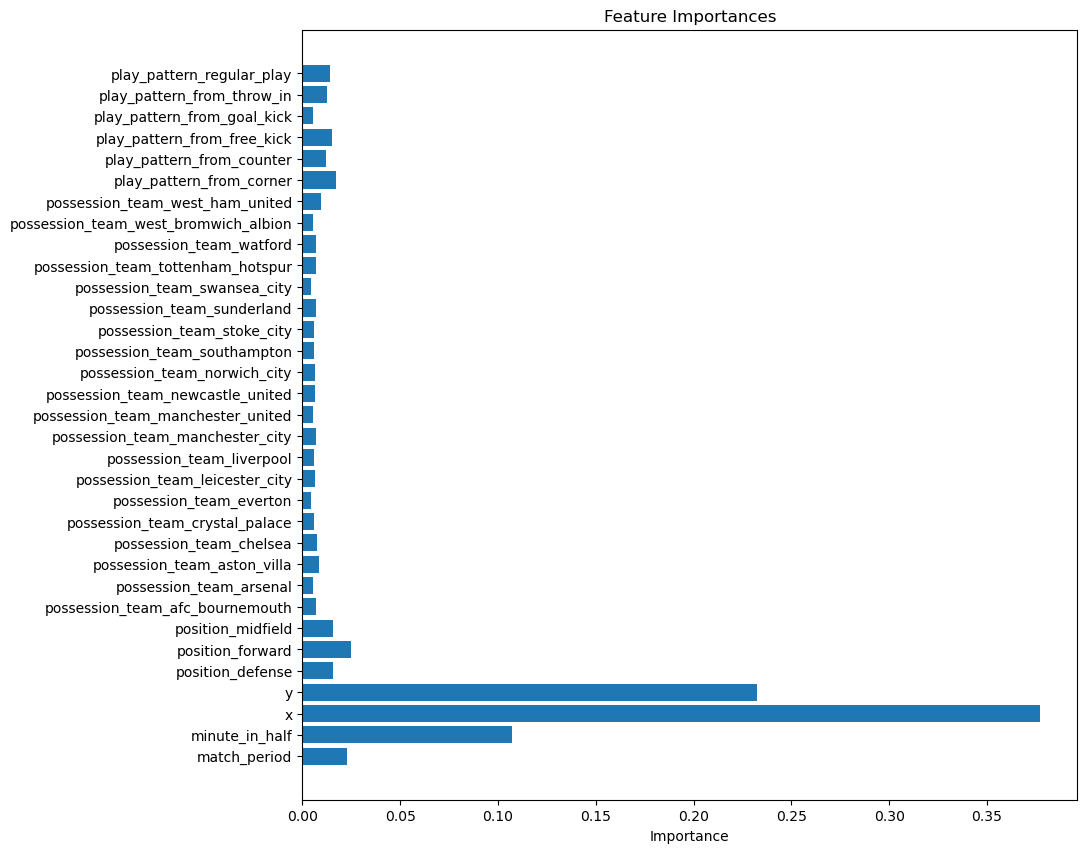

In [31]:
# Get feature importances
importances = model_rf.named_steps['classifier'].feature_importances_
print(importances)
# Get feature names after OneHotEncoding
feature_names = numeric_features + list(model_rf.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

### Use the Random Forest Model because of a higher F1 score on 1's

In [32]:
joblib.dump(model_rf, "../src/eplgoalsmodel_rf.pkl")

['../src/eplgoalsmodel_rf.pkl']

In [33]:
team_goals_imp = joblib.load("../src/eplgoalsmodel_rf.pkl")

2025-04-14 21:20:46.380 
  command:

    streamlit run c:\Users\vchan\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

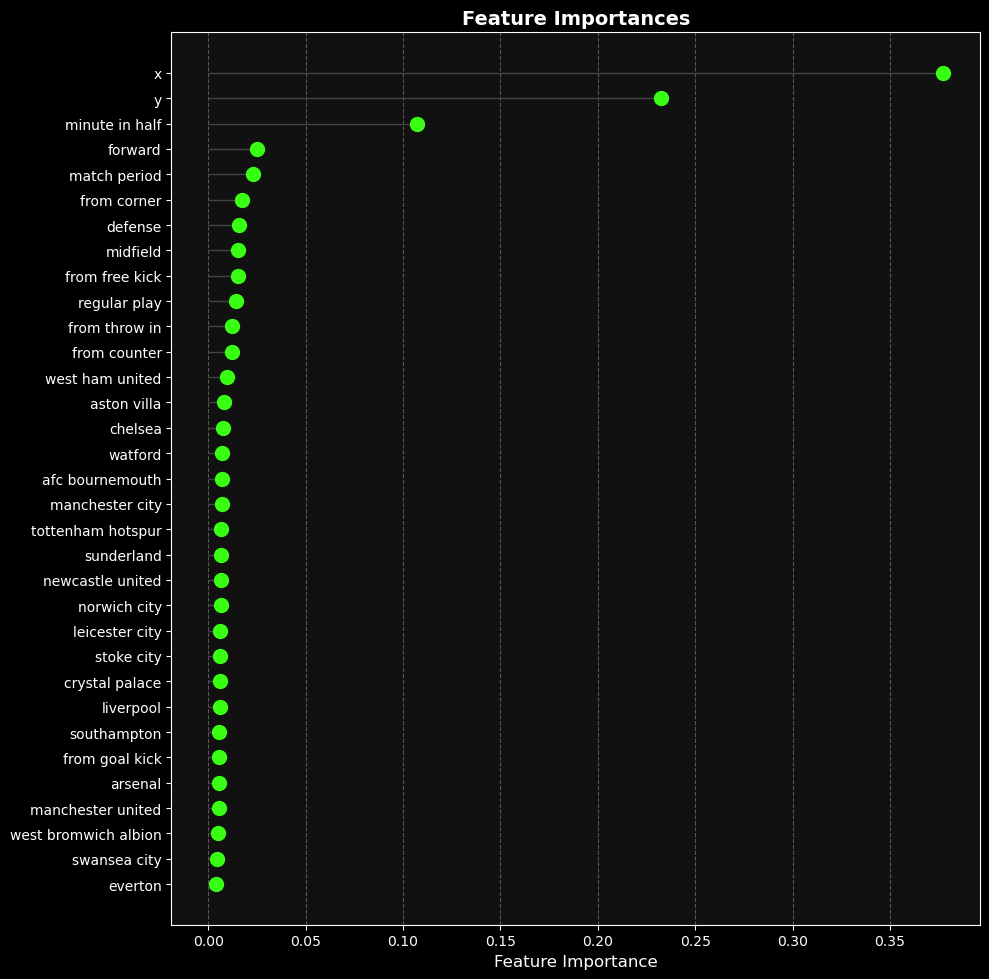

In [34]:
# Clean feature names
def clean_name(name):
    name = name.lower()
    if 'play_pattern_' in name:
        name = name.replace('play_pattern_', '')
    elif 'possession_team_' in name:
        name = name.replace('possession_team_', '')
    elif 'position_' in name:
        name = name.replace('position_', '')
    return name.replace('_', ' ')

# Sort by importance
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_features = [clean_name(feature_names[i]) for i in sorted_idx]

# Dark mode styling
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, len(sorted_features) * 0.3))
ax.set_facecolor('#111111')  # darker pitch background

# Draw lollipop chart
ax.hlines(y=sorted_features, xmin=0, xmax=sorted_importances, color='#444', linewidth=1)
ax.plot(sorted_importances, sorted_features, "o", markersize=10, color='#39ff14')  # neon green

# Axes and labels
ax.set_xlabel("Feature Importance", fontsize=12, color='white')
ax.set_title("Feature Importances", fontsize=14, color='white', weight='bold')
ax.tick_params(colors='white', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='white')
fig.tight_layout()

# Streamlit:
st.pyplot(fig)

In [35]:
X_train.dtypes

match_period         int64
minute_in_half       int64
possession_team     object
play_pattern        object
position            object
x                  float64
y                  float64
dtype: object